# <center>Lab 2: Linear Regression, Ridge Regression, Gradient Descent</center>
<center>DATA 558, Spring 2021</center>
<center>TAs: Alec Greaves-Tunnell and Ronak Mehta</center>

## 0. Overview

In this lab, we will cover:
- Running ordinary least-squares linear regression (OLS) using `sklearn`.
- Training performance metrics such as RSS, RSE, and $R^2$.
- Generalization performance metrics such MSE.
- Handling qualitative predictors using `pandas`.
- Running regularized least-squares ridge regression (RLS) using `sklearn`.
- The bias-variance tradeoff and the statistical view of regularization.
- Gradient descent for oracle-based convex optimization.
- The optimization perspective on regularization.

## 1. Ordinary Least-Squares Linear Regression (OLS)

Let $(x, y) \sim P_{x, y}$ be a random variable, where $x$ is observed in $\mathbb{R}^{p+1}$ and $y$ is observed in $\mathbb{R}$. $x$ is referred to as the *input* or *example*, and $y$ is referred to as the *output*, *label*, or *response*. We use $\mathbb{R}^{p+1}$ because $x$ is assumed to have $1$ as its first entry, followed by $p$ *features* $x^{(1)}, \ldots, x^{(p)}$. That is,
$$
x = \begin{bmatrix} 1 \\ x^{(1)} \\ \vdots \\ x^{(p)}\end{bmatrix}
$$
The *ordinary least-squares linear regression* (OLS) method wishes to find a linear function from $\mathbb{R}^{p+1}$ to $\mathbb{R}$ that can accurately predict $y$ from a given $x$. Specifically, we would like the $\beta \in \mathbb{R}^{p+1}$ that minimizes
$$
\mathbb{E}_{x, y \sim P_{x, y}}\left[(y - \beta^\top x)^2\right]
$$
This depends on the joint distribution $P_{x,y}$, to which we do not have access. Instead, we are given a training set $(x_1, y_1), ..., (x_n, y_n)$ with $x_i \in \mathbb{R}^{p+1}$ and $y_i \in \mathbb{R}$ for $i = 1, ..., n$, and estimate $\beta$ by minimizing the objective
$$
\frac{1}{n} \sum_{i=1}^n (y_i - \beta^\top x_i)^2.
$$
In this section, we show how to find the optimal $\beta$ using `sklearn`.

### 1.1. Performance Measures for Training

We first define a few performance measures that will come up often. Let $\hat{y}_i = \beta^\top x_i$ be the predicted response for data point $x_i$ for a particular choice of $\beta$. The *residual sum-of-squares* ($\text{RSS}$) is defined as

$$
\text{RSS} = \sum_{i=1}^n (y_i - \hat{y}_i)^2 = \sum_{i=1}^n (y_i - \beta^\top x_i)^2.
$$

Implicitly, this is a function of $\beta$. Define the vector

$$
y = \begin{bmatrix} y_1 \\ \vdots \\ y_n\end{bmatrix} \in \mathbb{R}^n
$$

and the matrix

$$
X = \begin{bmatrix} x_1^\top \\ \vdots \\ x^\top_n\end{bmatrix} = \begin{bmatrix} 1 & x^{(1)}_1 & \ldots & x^{(p)}_1 \\ \vdots & \vdots & \ddots & \vdots \\ 1 & x^{(1)}_n & \ldots & x^{(p)}_n\end{bmatrix} \in \mathbb{R}^{n \times (p+1)}.
$$

Note that we overloaded then notation for $y$, but it should be clear from context. $\text{RSS}$ can also be written compactly as

$$
\text{RSS} = (y - X\beta)^\top (y - X\beta) = || y-X\beta||_2^2
$$

This is exactly the same objective as above, and is what is minimized by OLS to estimate $\beta$.

One key statistical fact is that if we assume that $x_1, ..., x_n$ are fixed, and each $y_i \sim \mathcal{N}(\beta^\top x_i, \sigma^2)$ for some $\beta \in \mathbb{R}^{p+1}$, then we have that

$$
\frac{1}{\sigma^2} \text{RSS} \sim \chi^2_{n - p - 1}
$$

This fact is used to derive hypothesis tests that compare the performance of models, usefulness of predictors, etc.

Let us instantiate all of these terms on data. The [Advertising](https://www.kaggle.com/ishaanv/ISLR-Auto?select=Advertising.csv) dataset contains contains statistics about the sales of a product in 200 different markets, together with advertising budgets in each of these markets for different media channels: TV, radio and newspaper. The sales are in thousands of units and the budget is in thousands of dollars.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# `index_col` specificies that the first column contains indices.
ad_data = pd.read_csv('Advertising.csv', index_col=0)
ad_data.head(5)

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [3]:
X = ad_data[["TV", "Radio", "Newspaper"]].to_numpy() # Index with a list of columns.
y = ad_data["Sales"].to_numpy()                      # Index with a single column.

n, p = X.shape

print("Sample size: n =", n)
print("Dimension: p =", p)

print("X shape:", X.shape) # Should be 2D array.
print("y shape:", y.shape) # Should be 1D array.

Sample size: n = 200
Dimension: p = 3
X shape: (200, 3)
y shape: (200,)


In [4]:
# Docs: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression

In [5]:
lr = LinearRegression() # Create algorithm object (common to all of sklearn).
lr.fit(X, y)            # Fit to data. We do not have to append the intercept because 'fit_intercept = True'

LinearRegression()

When running more computationally expensive procedures, it is usually good practice to have imports, fitting, and evaluation in different cells. This will not be a big issue for linear regression.

In [6]:
bias = np.array(lr.intercept_).reshape((1,))
weights = lr.coef_
beta = np.concatenate([bias, weights])
print("beta:", beta)

beta: [ 2.93888937e+00  4.57646455e-02  1.88530017e-01 -1.03749304e-03]


In [7]:
yhat = lr.predict(X)
RSS = np.dot(y - yhat, y - yhat)

print("RSS:", RSS)

RSS: 556.8252629021872


In [8]:
np.linalg.norm((y-yhat))**2 # RSS is the squared 2-norm of the residuals

556.8252629021872

Another, slightly more interpretable measure is the *residual standard error* ($\text{RSE}$), which is computed as

$$
\text{RSE} = \sqrt{\frac{1}{n-p-1}\text{RSS}} = \sqrt{\frac{1}{n-p-1}\sum_{i=1}^n (y_i - \hat{y}_i)^2}
$$

Roughly speaking, it is the average amount that the response will deviate from the regression line. Notably, the measure is in the same units as the response.

In [9]:
RSE = np.sqrt(RSS / (n - p - 1))

print("RSE:", RSE)

RSE: 1.685510373414744


Thus, the predicted sales are about \$1,686 off from the actual sales on average.

**Exercise 1.1:** Compare and contrast RSS vs RSE as error metrics. Which has a more natural statistical definition? Which is easier to interpret in terms of the response?

One can equivalently think of the optimal $\beta$ as minimizing $\text{RSE}$, as multiplying by the positive constant ($\frac{1}{n-p-1}$) or applying a monotonically increasing function ($\sqrt{\cdot}$) does not change the optimum. Two important notes:
- $\text{RSS}$ and $\text{RSE}$ are computed on the *training set*. $\beta$ is *selected specifically to minimize* $\text{RSS}$, so it is not a reliable measure of the model's *generalization error*. 
- $\text{RSS}$ can be computed for any model, not just the linear model. In other contexts, we will usually just call it squared loss. $\text{RSE}$, while it can be computed, is more specific to linear models.

One final performance measure on the training set is the $R^2$ statistic. Because $\text{RSE}$ is measured in the units of the response, it is not always clear what constitutes a "good" value of $\text{RSE}$. The $R^2$ statistic provides an alternate measure that is bounded between $0$ and $1$. While $\text{RSS}$ and $\text{RSE}$ are measures of *lack of fit*, $R^2$ measures *goodness of fit*. To compute it, first define *total sum of squares* ($\text{TSS}$) as

$$
\text{TSS} = \sum_{i=1}^n (y_i - \bar{y})^2,
$$

where $\bar{y} = \frac{1}{n} \sum_{i=1}^n y_i$ is the sample average of the responses. $\text{TSS}$ is also the $\text{RSS}$ when using a model with $0$ features (only an intercept). The $\text{TSS}$ measures the total variability inherent in the response before the regression is performed. We then define $R^2$ as

$$
R^2 = \frac{\text{TSS} - \text{RSS}}{\text{TSS}} = 1 - \frac{\text{RSS}}{\text{TSS}}.
$$

This is guaranteed to be between $0$ and $1$ because of the identity

$$
\sum_{i=1}^n (y_i - \bar{y})^2 = \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \sum_{i=1}^n (\hat{y}_i - \bar{y})^2
$$

Because $R^2$ is *unitless*, it is clear that close to $1$ means "good" and close to $0$. Also note that the threshold for "good" and "bad" vary by field.

In [10]:
from sklearn.metrics import r2_score

print("R^2:", r2_score(y, yhat))

R^2: 0.8972106381789522


Because $0.90$ is close to $1$, this indicates a good fit.

### 1.2. Performance Measures for Generalization Error

All of the previous performance measures are evaluated on the training set to ensure that the optimization is performed correctly. To evaluate generalization error, we will instead use (test) *mean squared error* ($\text{MSE}$). That is, letting $(x_1, y_1), ..., (x_n, y_n)$ denote the training set, we choose $\beta$ to minimize

$$
\text{RSS} = \sum_{i=1}^n (y_i - \hat{y}_i) = \sum_{i=1}^n (y_i - \beta^\top x_i).
$$

Then, using the $\beta$ from above, and test set $(x'_1, y'_1), ..., (x'_m, y'_m)$, we evaluate

$$
\text{MSS} = \frac{1}{m} \sum_{i=1}^m (y'_i - \hat{y}'_i) = \frac{1}{m}\sum_{i=1}^m (y'_i - \beta^\top x'_i).
$$

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

n = len(X_train)
m = len(X_test)

print("Training set size: n =", n)
print("Test set size: m =", m)

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

Training set size: n = 134
Test set size: m = 66
X_train shape (134, 3)
y_train shape (134,)
X_test shape (66, 3)
y_test shape (66,)


In [13]:
lr = LinearRegression()

lr.fit(X_train, y_train) # Fit to training set.

y_pred = lr.predict(X_test) # Predicted y on the test set.

MSE = mean_squared_error(y_test, y_pred)

print("MSE:", MSE)

MSE: 3.7279283306815105


To put it in the same units as the response, we can use the *root mean squared error* ($\text{RMSE}$)

$$
\text{RMSE} = \sqrt{\text{MSE}}
$$

In [14]:
print("RMSE:", np.sqrt(MSE))

RMSE: 1.9307843822347204


We can say more accurately that the predicted sales will be about \$1,931 off from the actual sales on average.

### 1.3. Qualitative Predictors

In the discussion above, we have assumed that our features/predictors were real-valued, i.e. *quantitative* or *numerical*. We can also consider predictors that are not numbers, but elements from a small, finite set of categories. These are called *qualitative* or *categorical* features/variables/predictors. Qualitative variables also called *factors*, with the categories called *levels*.

We will use as an example the [Carseats](https://rdrr.io/cran/ISLR/man/Carseats.html) dataset, a simulated dataset containing sales of child car seats at 400 different stores. Each store has 11 associated variables.
A data frame with 400 observations on the following 11 variables.

- `Sales` - Unit sales (in thousands) at each location
- `CompPrice` - Price charged by competitor at each location
- `Income` - Community income level (in thousands of dollars)
- `Advertising` - Local advertising budget for company at each location (in thousands of dollars)
- `Population` - Population size in region (in thousands)
- `Price` - Price company charges for car seats at each site
- `ShelveLoc` - A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site
- `Age` - Average age of the local population
- `Education` - Education level at each location
- `Urban` - A factor with levels No and Yes to indicate whether the store is in an urban or rural location
- `US` - A factor with levels No and Yes to indicate whether the store is in the US or not

We consider `Sales` to be the response variable. The `ShelveLoc`, `Urban`, and `US` variables are qualitative, with 3, 2, and 2 levels, respectively. 

In [15]:
cs_data = pd.read_csv("Carseats.csv", index_col=0)
cs_data.head(10)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
5,4.15,141,64,3,340,128,Bad,38,13,Yes,No
6,10.81,124,113,13,501,72,Bad,78,16,No,Yes
7,6.63,115,105,0,45,108,Medium,71,15,Yes,No
8,11.85,136,81,15,425,120,Good,67,10,Yes,Yes
9,6.54,132,110,0,108,124,Medium,76,10,No,No
10,4.69,132,113,0,131,124,Medium,76,17,No,Yes


We wil encode the categorical predictors by constructing _dummy variables_. For a given categorical variable with _n_ levels, we construct _n-1_ columns that take the value 1 if an observation has that level and 0 otherwise. The omitted level becomes the "baseline," with the estimated coefficients for each dummy variable describing the "contrast" from the baseline to the corresponding level.

We'll spend more time considering data preprocessing and representation in a later lab. For now, it suffices to say that the function `pd.get_dummies()` automatically constructs dummies for categorical variables in a DataFrame, and the `drop_first=True` argument can be used to set the first level of each categorical varaible as the "baseline."

In [16]:
cs_data_dummies = pd.get_dummies(cs_data.iloc[:,1:], drop_first=True)
cs_data_dummies.head(5)

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
1,138,73,11,276,120,42,17,0,0,1,1
2,111,48,16,260,83,65,10,1,0,1,1
3,113,35,10,269,80,59,12,0,1,1,1
4,117,100,4,466,97,55,14,0,1,1,1
5,141,64,3,340,128,38,13,0,0,1,0


**Note:** The discussion of dummy versus one-hot encoding is only relevant for *inference* or *estimation*, i.e. saying something about the actual values within the $\beta$ vector. If we only care about *prediction*, i.e. predicting $y$ from $x$, either encoding will yield the same result.

After this step, the analysis goes through as it would for quantitative predictors. We can reuse the code from above and assess the linear model.

In [17]:
X = cs_data_dummies.to_numpy()
y = cs_data["Sales"].to_numpy()

In [18]:
n, p = X.shape

print("Sample size: n =", n)
print("Dimension: p =", p)

print("X shape:", X.shape) # Should be 2D array.
print("y shape:", y.shape) # Should be 1D array.

Sample size: n = 400
Dimension: p = 11
X shape: (400, 11)
y shape: (400,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

n = len(X_train)
m = len(X_test)

print("Training set size: n =", n)
print("Test set size: m =", m)
print("")

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)
print("")

lr = LinearRegression()
lr.fit(X_train, y_train) # Fit to training set.
y_pred = lr.predict(X_test) # Predicted y on the test set.
MSE = mean_squared_error(y_test, y_pred)

print("MSE:", MSE)
print("RMSE:", np.sqrt(MSE))

Training set size: n = 268
Test set size: m = 132

X_train shape (268, 11)
y_train shape (268,)
X_test shape (132, 11)
y_test shape (132,)

MSE: 1.120204674859564
RMSE: 1.0583972197901712


Let's say that we would like to try various combinations of predictors in order to see when combination generalizes the best. At this point, it would be good practice to package up our analysis into a function, and take these combinations as input. Try to avoid code duplication where you can.

For this case specifically, because we would like to train and test on the same examples, we have to do the splitting step before encoding the datasets. There are many ways to do this, this is just one possible solutions.

In [20]:
test_size = 0.33

n = len(cs_data)
n_test = int(test_size * n) # Round down to nearest int.

test_idx = np.random.choice(np.arange(n), size=n_test)
train_idx = np.delete(np.arange(n), test_idx)

In [21]:
# Quickly check that the indices do not overlap and cover all examples.
print("n =", len(test_idx) + len(train_idx))
print("n_train + n_test =", len(train_idx) + len(test_idx))
print("Intersection:", np.intersect1d(train_idx, test_idx))

n = 419
n_train + n_test = 419
Intersection: []


In [22]:
def evaluate(column_names):
    X = pd.get_dummies(cs_data[column_names], drop_first=True).to_numpy()
    y = cs_data["Sales"].to_numpy()
    
    X_train, y_train = X[train_idx, :], y[train_idx]
    X_test, y_test = X[test_idx, :], y[test_idx]
    
    lr = LinearRegression()
    lr.fit(X_train, y_train) 
    y_pred = lr.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    return MSE

In [23]:
# Display the columns.
print(list(cs_data.columns)[1:])

['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'ShelveLoc', 'Age', 'Education', 'Urban', 'US']


In [24]:
feature_sets = [
    ['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education'], # Only quantitative
    ['ShelveLoc', 'Urban', 'US'],                                                      # Only qualitative
    ['CompPrice', 'Advertising', 'Price', 'Age', 'Urban'],                             # Odds
    ['Income', 'Population', 'ShelveLoc', 'Education', 'US'],                          # Evens
]

In [25]:
for feature_set in feature_sets:
    print("Features:", feature_set)
    print("MSE:", evaluate(feature_set))
    print("")

Features: ['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education']
MSE: 4.284963540413245

Features: ['ShelveLoc', 'Urban', 'US']
MSE: 4.850896421384482

Features: ['CompPrice', 'Advertising', 'Price', 'Age', 'Urban']
MSE: 4.263182648819037

Features: ['Income', 'Population', 'ShelveLoc', 'Education', 'US']
MSE: 4.894829355292011



Rather than random sets of features, we may be interested in ordering sets by increasing costs of data collection, or try to assess feature important by observing the results of dropping each feature from the model one-by-one.

## 2. Ridge Regression 

In this section, we will introduce *regularized* least-squares linear regression. Specifically, we will cover a *shrinkage estimator* for the optimal $\beta$, by means of ridge regression (also known as $\ell^2$-regularized linear regression). To do so, we will first motivate the need for such methods intuitively and mathematically.

### 2.1. Motivation

The need for regularization especially comes up in *high-dimensional* data (see ISLR Section 6.4). In the examples we have seen so far, we had that $n >> p$, that is the number of observations was far greater than the number of predictors. When $p > n$, and $X$ is full-rank, the linear system

$$
X\beta = y
$$

will not in general have a unique solution $\beta$; in fact, there may be infinitely many solutions. That is, we can always find a perfect fit to the given data. This does *not* mean that the estimated $\beta$ will be a reasonable fit to *unseen* data. In fact, the generalization error will likely be substantial - a phenomenon known as *overfitting*. Consider Figure 6.22 from ISLR.
![Overfitting](img/islr_fig_6_22.jpeg)

The line estimated from the two data points on the right plot will perform badly in terms of test MSE on the data from left plot. ISLR defines the *high-dimensional setting* as that for which either $p > n$ or $p \approx n$. These issues can come up even if there are more data than predictors.

To be clear, both training MSE and training $R^2$ *will necessarily become better by adding more features to the data, even if those features are completely unrelated to the response*. This is because the learning algorithm is "fitting noise", i.e. relationships that are unique to the particular training set but unrelated to the overall relationship between $x$ and $y$. On the other hand, if the model chosen is too simple (one or zero predictors, say), the learning algorithm might not even be able to fit the training data!

### 2.2. The Bias-Variance Tradeoff

How do we quantify the tradeoff between simple and complex models? One framework in particular is pervasive in machine learning: the *bias-variance tradeoff*. We given one particular instantiation in terms of linear regression.

To set this up, let $x \in \mathbb{R}^{p+1}$ be a fixed feature vector and let $y = f(x) + \epsilon$, where $f: \mathbb{R}^{p+1} \rightarrow \mathbb{R}$ is some labelling function, and $\epsilon \sim \mathcal{N}(0, \sigma^2)$. This implies 

$$
y \sim \mathcal{N}(f(x), \sigma^2).
$$ 

Next, say we have an arbitrary supervised learning algorithm (not necessarily OLS) that approximates $f$ with a linear function $f(x) \approx \hat{\beta}^\top x$ learned from training data $(x_1, y_1), ..., (x_n, y_n)$. $\hat{\beta}$ is a random variable, because it is learned from randomly drawn data. Thus, we can define its expected value

$$
\bar{\beta} = \mathbb{E}\left[\hat{\beta}\right]
$$

This is the average over *all possible training sets* used to learn $\hat{\beta}$. It also follows that $\bar{\beta}^\top x = \mathbb{E}\left[\hat{\beta}^\top x\right]$. Note that both $\bar{\beta}$ and $\bar{\beta}^\top x$ are constants. We will define three quantities of importance.

- $\text{Var}(\epsilon) = \sigma^2$
is called the *irreducible error*, because it is the error of the true-but-unknown function $f$ that generated $y$. We cannot do better than this, even if the other two terms are zero. *This does not depend on the sample size or the choice of learning algorithm.*

- $\text{Bias}(\hat{\beta}) = \bar{\beta}^\top x - f(x)$
is the *bias*. This measures how close the *average* predictor that we learn (over all possible training sets) is to the true generating function $f$. *This usually does not depend on the sample size, but only on our choice of learning algorithm.* 

- $\text{Var}(\hat{\beta}) = \mathbb{E}_{\hat{\beta}}\left[(\bar{\beta}^\top x - \hat{\beta}^\top x)^2\right]$
is the *variance*. This measures how much the learning algorithm's answer changes when given different training sets. *This depends on the sample size and our choice of learning algorithm.*

![BiasVariance](img/bullseye.png)

How should we weigh bias and variance against one another? Up until this point, we were using MSE to evaluate our models. It turns out that there is a key relationship between bias, variance, and MSE. First, define the population MSE as

$$
\text{MSE}(\hat{\beta}) = \mathbb{E}_{y, \hat{\beta}}\left[(y - \hat{\beta}^\top x)^2 \right].
$$

The $y, \hat{\beta}$ subscript indicates that the expected value is taken over both the randomness in $y$ and in $\hat{\beta}$. Note that unlike training or test MSE, this is not a statistic computed on a dataset; instead, it is a population constant defined by the distribution of our input-label pairs. Remarkably, MSE decomposes into the sum of irreducible error, bias squared, and variance. That is,

$$
\begin{align*}
\text{MSE}(\hat{\beta}) &= \sigma^2 + \left(\text{Bias}(\hat{\beta})\right)^2 + \text{Var}\left(\hat{\beta}^\top x\right),
\end{align*}
$$

We show this fact below. The computation is a little hairy, but try to work through it step-by-step. Reform the expression as follows.

$$
\begin{align*}
\text{MSE}(\hat{\beta}) &= \mathbb{E}_{y, \hat{\beta}}\left[(y - \hat{\beta}^\top x)^2 \right]\\
&= \mathbb{E}_{y, \hat{\beta}}\left[(y - \bar{\beta}^\top x + \bar{\beta}^\top x - \hat{\beta}^\top x)^2 \right]\\
&= \mathbb{E}_{y, \hat{\beta}}\left[\left( (y - \bar{\beta}^\top x) + (\bar{\beta}^\top x - \hat{\beta}^\top x)\right)^2 \right]\\
&= \mathbb{E}_{y, \hat{\beta}}\left[(y - \bar{\beta}^\top x)^2\right]
+2\mathbb{E}_{y, \hat{\beta}}\left[(y - \bar{\beta}^\top x)(\bar{\beta}^\top x - \hat{\beta}^\top x)\right]
+\mathbb{E}_{y, \hat{\beta}}\left[(\bar{\beta}^\top x - \hat{\beta}^\top x)^2\right]\\
&= \mathbb{E}_{y}\left[(y - \bar{\beta}^\top x)^2\right]
+2\mathbb{E}_{y, \hat{\beta}}\left[(y - \bar{\beta}^\top x)(\bar{\beta}^\top x - \hat{\beta}^\top x)\right]
+\mathbb{E}_{\hat{\beta}}\left[(\bar{\beta}^\top x - \hat{\beta}^\top x)^2\right]
\end{align*}
$$

In the last step, we simply removed the subscripts for elements that were not included in the corresponding expected value. We claim that the cross term is zero. This is because:

$$
\begin{align*}
\mathbb{E}_{y, \hat{\beta}}\left[(y - \bar{\beta}^\top x)(\bar{\beta}^\top x - \hat{\beta}^\top x)\right] &= 
\mathbb{E}_{y}\left[y - \bar{\beta}^\top x\right]\mathbb{E}_{\hat{\beta}}\left[\bar{\beta}^\top x - \hat{\beta}^\top x\right]
\end{align*}
$$

The expected value factors because $y$ and $\hat{\beta}$ are independent. Then, by definition, $\mathbb{E}_{\hat{\beta}}\left[\bar{\beta}^\top x - \hat{\beta}^\top x\right] = 0$. This means that

$$
\begin{align*}
\text{MSE}(\hat{\beta}) &= \mathbb{E}_{y}\left[(y - \bar{\beta}^\top x)^2\right]
+\mathbb{E}_{\hat{\beta}}\left[(\bar{\beta}^\top x - \hat{\beta}^\top x)^2\right]
\end{align*}
$$

Then, following a very similar calculation, we can show that the first term can be decomposed further into

$$
\mathbb{E}_{y}\left[(y - \bar{\beta}^\top x)^2\right] = \mathbb{E}_{y}\left[(y - f(x))^2\right] + \left(f(x) - \bar{\beta}^\top x\right)^2
$$

Observe that $\mathbb{E}_{y}\left[(y - f(x))^2\right] = \text{Var}(\epsilon) = \sigma^2$. Putting it all together, we have that

$$
\begin{align*}
\text{MSE}(\hat{\beta}) &= \sigma^2 + \left(f(x) - \bar{\beta}^\top x\right)^2 + \mathbb{E}_{\hat{\beta}}\left[(\bar{\beta}^\top x - \hat{\beta}^\top x)^2\right]\\
&= \sigma^2 + \left(\text{Bias}(\hat{\beta})\right)^2 + \text{Var}\left(\hat{\beta}^\top x\right),
\end{align*}
$$

where $\text{Bias}(\hat{\beta}) = \bar{\beta}^\top x - f(x)$ and $\text{Var}\left(\hat{\beta}^\top x\right)$ is defined as is standard. We're done!

### 2.3 Ridge Regression

How can we diagnose and remedy overfitting and other issues with high-dimensional data? Let us use the [Credit](https://rdrr.io/cran/ISLR/man/Credit.html) dataset as an example. This is a simulated data set containing information on 400 customers. The aim here is to predict which customers will default on their credit card debt. We have access to the following variables.

- `ID` - Identification
- `Income` - Income in \$10,000's
- `Limit` - Credit limit
- `Rating` - Credit rating
- `Cards` - Number of credit cards
- `Age` - Age in years
- `Education` - Number of years of education
- `Gender` - A factor with levels Male and Female
- `Student` - A factor with levels No and Yes indicating whether the individual was a student
- `Married` -A factor with levels No and Yes indicating whether the individual was married
- `Ethnicity` - A factor with levels African American, Asian, and Caucasian indicating the individual's ethnicity
- `Balance` - Average credit card balance in \$.

The response variable is `Balance`.

In [26]:
credit_data = pd.read_csv("Credit.csv", index_col=0)
credit_data.head(10)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
6,80.180,8047,569,4,77,10,Male,No,No,Caucasian,1151
7,20.996,3388,259,2,37,12,Female,No,No,African American,203
8,71.408,7114,512,2,87,9,Male,No,No,Asian,872
9,15.125,3300,266,5,66,13,Female,No,No,Caucasian,279
10,71.061,6819,491,3,41,19,Female,Yes,Yes,African American,1350


In [27]:
credit_data_dummies = pd.get_dummies(credit_data.iloc[:,:-1], drop_first=True) # All but last column.
credit_data_dummies.head()

,Income,Limit,Rating,Cards,Age,Education,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
1,14.891,3606,283,2,34,11,0,0,1,0,1
2,106.025,6645,483,3,82,15,1,1,1,1,0
3,104.593,7075,514,4,71,11,0,0,0,1,0
4,148.924,9504,681,3,36,11,1,0,0,1,0
5,55.882,4897,357,2,68,16,0,0,1,0,1


In [28]:
X = credit_data_dummies.to_numpy()
y = credit_data["Balance"].to_numpy()

print("Sample size: n =", n)
print("Dimension: p =", p)

print("X shape:", X.shape)
print("y shape:", y.shape)

Sample size: n = 400
Dimension: p = 11
X shape: (400, 11)
y shape: (400,)


Let's see how well OLS generalizes.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)
lr = LinearRegression().fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

train_MSE = mean_squared_error(y_train, y_pred_train)
test_MSE = mean_squared_error(y_test, y_pred_test)

print("Training MSE:", train_MSE)
print("Test MSE:", test_MSE)

Training MSE: 8911.802887992526
Test MSE: 11220.789566998528


Can we make it so that training and test error are similar?

As before, consider dataset $(x_1, y_1), ..., (x_n, y_n)$, in which we assume $y_i = \beta^\top x_i + \epsilon_i$ for some $\beta \in \mathbb{R}^{p+1}$ and $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$. The *ridge regression* objective is given by

$$
\frac{1}{n}\sum_{i=1}^n (y_i - \beta^\top x_i)^2 + \frac{\lambda}{n} ||\beta||_2^2,
$$

where $\lambda > 0$ is called the *regularization hyperparameter*, and 

$$
||\beta||^2_2 = \sum_{j=0}^p \beta^{(j)} = \beta^\top \beta
$$

is the squared $\ell^2$-norm (pronounce "ell 2") of $\beta$. This combines two, often competing, objectives into one, weighed against each other by $\lambda$. The first term is the same as before, which privileges a $\hat{\beta}$ that fits the data well. The second term, on the other hand, privileges a $\hat{\beta}$ that has small weights. This clearly biases our result, as we will produce a $\hat{\beta}$ whose expected value $\bar{\beta}$ has smaller weights that the true $\beta$. Why might we want to do this?

Intuitively, if we shrink the weights, they will vary less, as we have curbed how large the deviation of the weights can be from their mean. Consider as an extreme case, the algorithm that returns $\hat{\beta} = \mathbf{0}_{p+1}$ every time. There is no absolutely no variance! Can this happen? It depends on the choice of $\lambda$.

As mentioned before, $\lambda$ manages the tradeoff between the two objectives, hence managing the bias-variance tradeoff by extension. When $\lambda = 0$, we recover the OLS objective, and will have no bias but possibly high variance. On the other hand, when $\lambda \rightarrow \infty$, we have $\hat{\beta} \rightarrow \mathbf{0}_{p+1}$, meaning we will have no variance but possibly high bias. First, we will visualize various values of the bias, variance, and MSE for different choices of $\lambda$.

As a last point, it very important to *standardize* the inputs before applying regularization. The reason is that if the variables are of different scales (i.e. house price, and number of bedrooms), a differing amount of regularization is being applied to each variable. To do so, replace each training example $x_i$ with $\tilde{x}_i$, where $\tilde{x}_i$ is defined by

$$
\tilde{x}^{(j)}_{i} = \frac{x^{(j)}_{i} - \overline{x^{(j)}}}{\sqrt{\frac{1}{n} \sum_{i=1}^n (x^{(j)}_{i} - \overline{x^{(j)}})^2}},
$$

where

$$
\overline{x^{(j)}} = \frac{1}{n} \sum_{i=1}^n x^{(j)}_i
$$


**Exercise 2.1:** Recall that $x^{(j)}_i$ is the value of the $j$-th feature for the $i$-th example. Explain in words what is meant by each of:
- $\overline{x^{(j)}}$
- $\sqrt{\frac{1}{n} \sum_{i=1}^n (x^{(j)}_{i} - \overline{x^{(j)}})^2}$
- $\tilde{x}^{(j)}_{i}$

We return to the Credit dataset. For now, we use the `StandardScaler` from `sklearn` to compute the standarization.

In [30]:
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

First, we fit a ridge regression model for $\lambda$ values ranging uniformly on a log scale from $10^{-2}$ to $10^6$.

In [31]:
lambdas = np.logspace(-2, 6, 1000)

# Important before ridge regression! See page 217 of ISLR.
X_transformed = StandardScaler().fit_transform(X)
# Homework: replace with below.
# X_transformed = standardize(X)

betas = defaultdict(list)
ratios = []
features = list(credit_data_dummies.columns)

beta_unreg = LinearRegression().fit(X_transformed,y).coef_

for lambda_ in lambdas:
    beta_reg = Ridge(alpha=lambda_).fit(X_transformed,y).coef_
    ratio = np.linalg.norm(beta_reg, ord=2) / np.linalg.norm(beta_unreg, ord=2)
    ratios.append(ratio)
    for j, feature in enumerate(features):
        betas[feature].append(beta_reg[j])

Then, we plot the coefficients $\beta^{(1)}, ..., \beta^{(p)}$ (where $p = 11$), against two sets of values. The first is the $\lambda$ hyperparameter. We expect all of the lines to shrink as $\lambda \rightarrow \infty$. The second is the ratio of $||\hat{\beta}^{\text{RLS}}_\lambda||_2$ (the $\ell^2$-norm of the regularized solution) against $||\hat{\beta}||_2$ (the $\ell_2$-norm of the unregularized solution). We expect the coefficients to generally be increasing in absolute value with this quantity.

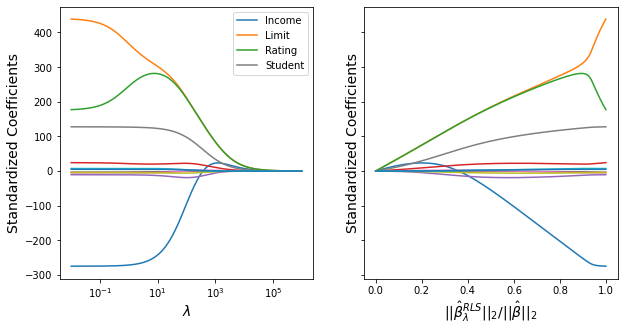

In [32]:
# Figure 6.4 of ISLR.

labels = {
    "Income" : "Income",
    "Limit" : "Limit",
    "Rating" : "Rating",
    "Student_Yes" : "Student"
}

fig, axes = plt.subplots(1, 2, sharey=True, figsize = (10, 5))

for feature in features:
    if feature in labels:
        axes[0].plot(lambdas, betas[feature], label=labels[feature])
    else:
        axes[0].plot(lambdas, betas[feature])
    axes[0].set_xscale('log')
    axes[1].plot(ratios, betas[feature])
    
fontsize = 14
axes[1].set_xlim(-0.05, 1.05)

axes[0].set_xlabel(r"$\lambda$", fontsize=fontsize)
axes[1].set_xlabel(r"$||\hat{\beta}^{RLS}_\lambda||_2 / ||\hat{\beta}||_2$", fontsize=fontsize)
axes[0].set_ylabel("Standardized Coefficients", fontsize=fontsize)
axes[1].set_ylabel("Standardized Coefficients", fontsize=fontsize)

axes[0].legend(loc = "upper right")
plt.show()

Now, we use a simulated dataset to inspect the bias and variance tradeoff plotted against the same quantities. The setup is the same as before, with a randomly generated $X$, $y$, (true) $\beta$, and $x$.

In [33]:
def get_data(n, p, sigma2, scale=1, seed=123):
    if seed:
        np.random.seed(seed)
        
    X = np.random.normal(size=(n,p))
    epsilon = np.random.normal(size=(n,), scale=sigma2)
    beta =  scale * (np.ones((p,)) + np.random.normal(size=(p,)))
    y = np.dot(X, beta) + epsilon
    x = np.random.normal(size=(p,))
    inv_cov = np.linalg.inv(X.T @ X / n)
    
    return X, y, beta, x, inv_cov

In [34]:
def bias(lambda_):
    B = np.eye(p) + lambda_ * inv_cov / n
    z = np.linalg.solve(B, x)
    
    return np.dot(z - x, beta)

def variance(lambda_):
    B = np.eye(p) + lambda_ * inv_cov / n
    z = np.linalg.solve(B, x)
    
    return sigma2 * np.dot(z, np.dot(inv_cov, z)) / n

def ratio(lambda_):
    B = np.eye(p) + lambda_ * inv_cov / n
    beta_hat = np.dot(inv_cov @ X.T, y) / n
    u = beta_hat / np.linalg.norm(beta_hat)
    z = np.linalg.solve(B, u)
    
    return np.linalg.norm(z)

n = 50
p = 45
sigma2 = 1

X, y, beta, x, inv_cov = get_data(n, p, sigma2)
print(bias(0)) # Should be 0.
print(variance(10000)) # Should be 0.
print(ratio(0)) # Should be 1

0.0
1.4688562584978742e-05
1.0


In [35]:
def compute_metrics(X, y, beta, x, inv_cov, lambdas):
    biases_sq = np.square(np.array([bias(lambda_) for lambda_ in lambdas]))
    variances = np.array([variance(lambda_) for lambda_ in lambdas])
    ratios = np.array([ratio(lambda_) for lambda_ in lambdas])
    mses = sigma2 + biases_sq + variances
    
    return biases_sq, variances, ratios, mses

In [36]:
def plot_bias_variance_curve(lambdas, biases_sq, variances, ratios, mses):
    fig, axes = plt.subplots(1, 2, sharey=True, figsize = (10, 5))

    axes[0].plot(lambdas, biases_sq, color="black", label=r"Bias^2")
    axes[0].plot(lambdas, variances, color="green", label=r"Variance")
    axes[0].plot(lambdas, mses, color="red", label=r"MSE")

    axes[1].plot(ratios, biases_sq, color="black")
    axes[1].plot(ratios, variances, color="green")
    axes[1].plot(ratios, mses, color="red")
    
    var_unreg = variance(0)
    axes[0].hlines(var_unreg, np.min(lambdas), np.max(lambdas), color="black", linestyles="dashed")
    axes[1].hlines(var_unreg, 0, 1, color="black", linestyles="dashed")

    fontsize = 14
    axes[1].set_xlim(-0.05, 1.05)
    axes[0].set_xscale('log')

    axes[0].set_xlabel(r"$\lambda$", fontsize=fontsize)
    axes[1].set_xlabel(r"$||\hat{\beta}^{RLS}_\lambda||_2 / ||\hat{\beta}||_2$", fontsize=fontsize)
    axes[0].set_ylabel("Mean Squared Error", fontsize=fontsize)
    axes[1].set_ylabel("Mean Squared Error", fontsize=fontsize)

    axes[0].legend(loc = "upper left")
    plt.show()

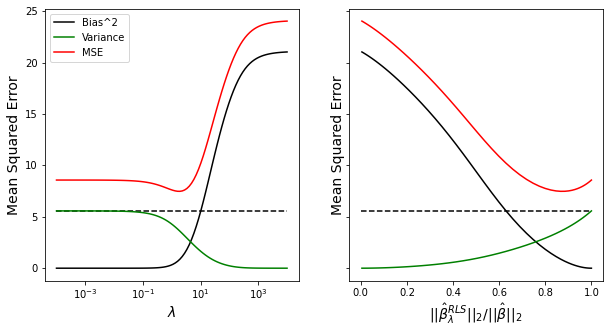

In [37]:
# Figure 6.5 of ISLR.

scale = 0.4
n = 65
p = 45
sigma2 = 3

lambdas = np.logspace(-4, 4, 100)
X, y, beta, x, inv_cov = get_data(n, p, sigma2,scale=scale)
biases_sq, variances, ratios, mses = compute_metrics(X, y, beta, x, inv_cov, lambdas)
plot_bias_variance_curve(lambdas, biases_sq, variances, ratios, mses)

Observe how as $\lambda$ becomes larger than $10^2$, the bias increases and then levels out (implying that ridge regression is just picking the zero vector at that point. Consequently, the variance is zero in this region. As the $\lambda$ becomes less than $10^0$, the bias is negligible because the true and regularized solution are essentially the same. The variance increases and then levels out.

**Exercise 2.2:** What quantity does the dashed horizontal line represent?

**Exercise 2.3:** Where can we find the irreducible error on the plot above?

## 3. Gradient Descent

In this section, we will shift gears from modeling to optimization. That is, we will go into the specifics of how to actually estimate the optimal $\beta$ after having written down the objective. A key point that we will see is that regularization plays a role not only in the statistics of machine learning but also in the optimization.

**Source**: This section is adapted from the "[Refresher Course in Matrix Analysis and Numerical Optimization](https://github.com/iutzeler/refresher-course)" at Université Grenoble Alpes.

### 3.1. Black-Box Optimization

We first cover the *black-box* or *oracle-based optimization* framework for convex, differentiable function. In this model, we assume access to an "oracle" that can evaluate the objective function and its gradient at a particular point, without further knowledge of the nature of the function. Contrast this with *parameter-based* optimization in which the objective function has some "parameters" that we know something about (for example, a quadratic function in which we know the Hessian and gradient).

Consider an objective function $f: \mathbb{R}^{n} \rightarrow \mathbb{R}$. The input to the oracle is $x \in \mathbb{R}^n$, and the output is the value $f(x) \in \mathbb{R}$ and the gradient $\nabla_x f(x)$. A basic convex optimization algorithm in this setting is *gradient descent*. To run gradient descent, we first randomly initialize a point $x_0 \in \mathbb{R}^n$. Then, we update the point according to

$$
x^{(t)} = x^{(t-1)} - \eta \nabla_x f(x^{(t-1)}),
$$

where $\eta > 0$ is the stepsize hyperparameter. If the gradient of the function is sufficiently smooth, and the step-size is small enough, then gradient descent will converge to an optimum at rate $O\left(\frac{1}{t}\right)$, where $t$ is the number of iterations. We will implement this algorithm on some simple examples.

In [38]:
from utils import *

Consider the following function $f: \mathbb{R}^2 \rightarrow \mathbb{R}$, given by
$$
f(x_1, x_2) = 4(x_1 - 3)^2 + 2(x_2 - 1)^2.
$$
![simple](img/simple.png)
This one is designed to be easy to optimize.

**Exercise 3.1:** Implement the function $f$ below. Feel free to use `numpy` functions.

In [39]:
def f(x):
    """Function f.

	Parameters
	----------
	x : numpy.ndarray
		A numpy array of size (2, m, m), where m^2 is the number of plotted points.

	Returns
	-------
	value : numpy.ndarray
		A numpy array of size (m, m), where value[i, j] = f(x[1, i, j], x[2, i, j]).
	"""
    x1 = x[0] # Size (m, m) array.
    x2 = x[1] # Size (m, m) array.
    
    # <YOUR CODE HERE>
    value = None
    ##
    
    return value

AttributeError: 'NoneType' object has no attribute 'ndim'

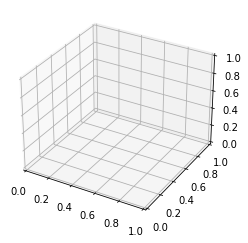

In [40]:
# Should look qualitatively similar to above.

f_plot_param  = {'x1_min' : -0.5, 'x1_max' : 5.5,
                 'x2_min' : -0.5, 'x2_max' : 5.5,
                 'nb_points' : 200,
                 'v_min' : 0, 'v_max' : 80, 'levels' : [0.5,1,2,5,10,15],
                 'title' : 'f: a simple function' }

custom_3dplot(f, f_plot_param)
level_plot(f, f_plot_param)

Second, consider the following function $g: \mathbb{R}^2 \rightarrow \mathbb{R}$, given by
$$
g(x_1, x_2) = \log( 1 + \exp(4 (x_1-3)^2 ) + \exp( 2(x_2-1)^2 ) ) - \log(3)
$$
![simple](img/harder.png)
This one is designed to be more pesky to optimize.

**Exercise 3.2:** Implement the function $g$ below. Feel free to use `numpy` functions.

In [ ]:
def g(x):
    """Function g.

	Parameters
	----------
	x : numpy.ndarray
		A numpy array of size (2, m, m), where m^2 is the number of plotted points.

	Returns
	-------
	value : numpy.ndarray
		A numpy array of size (m, m), where value[i, j] = g(x[1, i, j], x[2, i, j]).
	"""
    x1 = x[0] # Size (m, m) array.
    x2 = x[1] # Size (m, m) array.
    
    ## <YOUR CODE HERE>
    value = None
    ##
    
    return value

In [ ]:
# Should look qualitatively similar to above.

g_plot_param  = {'x1_min' : -0.5, 'x1_max' : 5.5,
                 'x2_min' : -0.5, 'x2_max' : 5.5,
                 'nb_points' : 500,
                 'v_min' : 0, 'v_max' : 10, 'levels' : [0.5,1,2,5,10,15],
                 'title' : 'g: a harder function' }

custom_3dplot(g, g_plot_param)
level_plot(g, g_plot_param)

**Exercise 3.3:** Implement the gradients $\nabla f$ and $\nabla g$ below.

In [ ]:
def f_grad(x):
    """Gradient of f.

	Parameters
	----------
	x : numpy.ndarray
		A numpy array of size (2,), containing x1 and x2.

	Returns
	-------
	grad : numpy.ndarray
		A numpy array of size (2,), containing df/dx1 and df/dx2
	"""
    
    ## <YOUR CODE HERE>
    grad = None
    ##
    
    return grad

def g_grad(x):
    """Gradient of g.

	Parameters
	----------
	x : numpy.ndarray
		A numpy array of size (2,), containing x1 and x2.

	Returns
	-------
	grad : numpy.ndarray
		A numpy array of size (2,), containing dg/dx1 and dg/dx2
	"""
    
    ## <YOUR CODE HERE>    
    grad = None
    ##
    
    return grad

While theory suggests that the gradient descent iterates converge to the optimum in the limit of infinite iterations, we are of course limited to a finite number of iterations when implementing the algorithm. Conditions for selecting the correct number of iterations are called *stopping criteria*. Multiple stopping criteria can be specified, in which case the algorithm terminates when any one of the criteria is satisfied. We consider two:
- Stop after a maximum number if iterations `iters` is reached.
- Stop after the squared norm of the gradient falls below `tol`.

**Exercise 3.4:** Implement gradient descent, assuming access to the gradient oracle. Initialize at $(0, 0)$.

In [ ]:
def gradient_descent_2d(f_grad, lr, iters, tol):
    """Gradient of g.

	Parameters
	----------
	f_grad : function
		A function the provides the gradient with respect to input x.
    lr : float
		Learning rate, or step size in optimization.
    iters : int
		Number of iterations to run GD.
    tol : float
		Tolerance for squared norm of the gradient.

	Returns
	-------
	iterates : list[numpy.ndarray]
		A list of numpy arrays, each of size (2,), containing x1 and x2 for each iteration of GD.
	"""
    
    # initialization and gradient at initial point
    x = np.array([0, 0])
    iterates = [x]
    grad = f_grad(x)
    
    t = 0 # iteration counter
    while t < iters and np.linalg.norm(grad) ** 2 > tol:
        ## <YOUR CODE HERE>
        # 1. update location by taking gradient step with step size lr
        
        # 2. compute gradient at new point
        
        # 3. add new point to iterates
        
        t += 1 # increment iteration counter
        
    return iterates

In [ ]:
from utils import gd_viz

**Exercise 3.5:** Choose a set of hyperparameters that allows gradient descent to optimize $f$. Experiment with the learning rate. What happens when it is set very small? Very large? Are there some cases in which the optimization fails?

In [ ]:
## <YOUR CODE HERE>
iters = None
lr = None
tol = None
##

iterates = gradient_descent_2d(f_grad, lr, iters, tol)

gd_viz(f, f_plot_param, iterates)

**Exercise 3.6:** Choose a set of hyperparameters that allow gradient descent to optimize $g$. As above, experiment with the algorithm settings. 

In [ ]:
## <YOUR CODE HERE>
iters = None
lr = None
tol = None
##

iterates = gradient_descent_2d(g_grad, lr, iters, tol)

gd_viz(g, g_plot_param, iterates)

### 3.2. Regularized Least-Squares Optimization (RLS)

In this final section, we explore ridge regression from an optimization viewpoint. It turns out that while regularization provides *statistical* benefits (by increasing performance for a fixed amount of data), it also can have *optimization* benefits (by more stably and more quickly reaching the optimal value).

Recall the ridge regression objective.

$$
L(\beta) = \frac{1}{n}\sum_{i=1}^n (y_i - \beta^\top x_i)^2 + \frac{\lambda}{n} ||\beta||_2^2,
$$

We will use our visualizations and gradient descent implementation from the previous sections to understand and solve this objective. We will then check our answer against that of `Ridge` in higher dimensions to make sure that we did it correctly.

**Exercise 3.7:** Implement the RLS objective function.

In [ ]:
def L(beta, lambda_, X, y):
    """L2 Regularized least-squares (RLS) objective.

	Parameters
	----------
	beta : numpy.ndarray
		A numpy array of size (p+1,), where p is the number of predictors.
    lambda_ : float
        Regularization hyperparameter.
    X : numpy.ndarray
        A numpy array of size (n,p+1), containing the design matrix.
    y : numpy.ndarray
        A numpy array of size (n,), containing the responses.

	Returns
	-------
	value : float
		A float representing the RLS objective.
	"""
    
    ## <YOUR CODE HERE>
    # 1. compute the linear prediction y_hat    
    # 2. compute the residual    
    # 3. compute the RLS objective as a function of the residual and beta
    value = None
    ##
    
    return value

**Exercise 3.8:** Implement the gradient of the RLS objective.

In [ ]:
def L_grad(beta, lambda_, X, y):
    """Derivative of RLS objective.

	Parameters
	----------
	beta : numpy.ndarray
		A numpy array of size (p+1,), where p is the number of predictors.
    lambda_ : float
        Regularization hyperparameter.
    X : numpy.ndarray
        A numpy array of size (n,p+1), containing the design matrix.
    y : numpy.ndarray
        A numpy array of size (n,), containing the responses.

	Returns
	-------
	grad : numpy.ndarray
		A numpy array of size (p+1,), containing the gradient dL/dbeta.
	"""
    
    ## <YOUR CODE HERE>
    grad = None
    ##
    
    return grad

**Exercise 3.9:** Implement gradient descent for general $d$ dimensional space. Pass `*args` to the function to contain `lambda_`, `X`, and `y`.

In [ ]:
def gradient_descent(L_grad, lr, iters, tol, *args):
    """Gradient of g.

	Parameters
	----------
	L_grad : function
		A function the provides the gradient with respect to input beta.
    lr : float
		Learning rate, or step size in optimization.
    iters : int
		Number of iterations to run GD.
    tol : float
		Tolerance for squared norm of the gradient.

	Returns
	-------
	iterates : list[numpy.ndarray]
		A list of numpy arrays, each of size (d,), containing the iterates of GD.
	"""
    
    # <YOUR CODE HERE>
    iterates = []
    ##

    return iterates

We will first check this algorithm on $d=2$ (i.e. $p=1$) to visualize the solution.

In [ ]:
beta_true = np.array([2, 0.5])

n = 100
sigma2 = 1

X = np.ones((n, 2))
X[:, 1] = np.random.normal(size=(n,))
epsilon = np.random.normal(size=(n,), scale=sigma2)
y = np.dot(X, beta_true) + epsilon
lambda_ = 0.001

iters = 4
lr = 0.3
tol = 1e-5

iterates = gradient_descent(L_grad, lr, iters, tol, lambda_, X, y)

rls_viz(L, iterates, beta_true, lambda_, X, y)

The lines fit the data (black dots) better and better with each iteration. Note that we implemented our loss function as a sum, meaning we'd generally want a smaller learning rate. Finally, we compare our answer to the various `sklearn` libraries we've been using up until this point.

**Exercise 3.10:** Generate a dataset of `X`, `y`, according to some `beta` with `p = 10`. Estimate `beta` using both `Ridge`, and our `gradient_descent` implementation. For what hyperparameters do the results look qualitatively similar? (For simplicity, ignore the intercept and specify `fit_intercept=False` for `Ridge`.

In [ ]:
## <YOUR CODE HERE>

##